In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [2]:
engine = create_engine('postgresql:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

In [3]:
start_date = '2021-04-01'
start_time = '2021-04-01 00:00:00'
end_date = '2021-06-30'
end_time = '2021-07-01 00:00:00'
one_year_ago = '2020-07-01'

In [4]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,8471941


In [5]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at::date < '{end_date}'
""", conn)

,downloads_to_date
0,48609840


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,764031


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,116486


In [8]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,386472


In [9]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{one_year_ago}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2020-07-01,1102139
1,2020-08-01,1737186
2,2020-09-01,1653471
3,2020-10-01,1850781
4,2020-11-01,1240661
5,2020-12-01,1552508
6,2021-01-01,1960137
7,2021-02-01,3424032
8,2021-03-01,3878585
9,2021-04-01,2956219


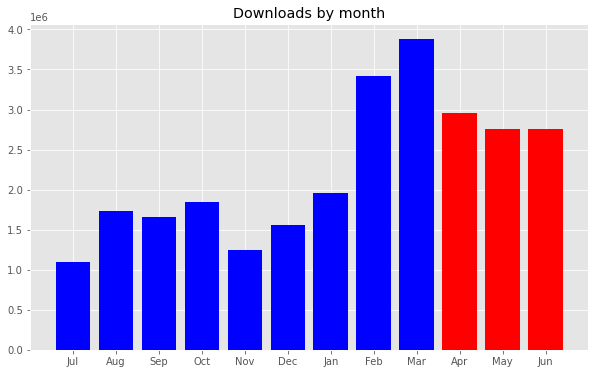

In [10]:
plt.rcParams["figure.figsize"] = (10, 6)

months = [m.month_name()[:3] for m in downloads_by_month['m']]
downloads = [c for c in downloads_by_month['c']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), downloads, color=colors)
plt.title('Downloads by month')
plt.xticks(range(12), months)

plt.savefig('downloads-by-month.png')

plt.show()

In [11]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

downloads_by_day

,d,downloads
0,2021-04-01,134775
1,2021-04-02,168082
2,2021-04-03,107416
3,2021-04-04,108983
4,2021-04-05,93094
...,...,...
86,2021-06-26,69684
87,2021-06-27,74094
88,2021-06-28,104068
89,2021-06-29,131575


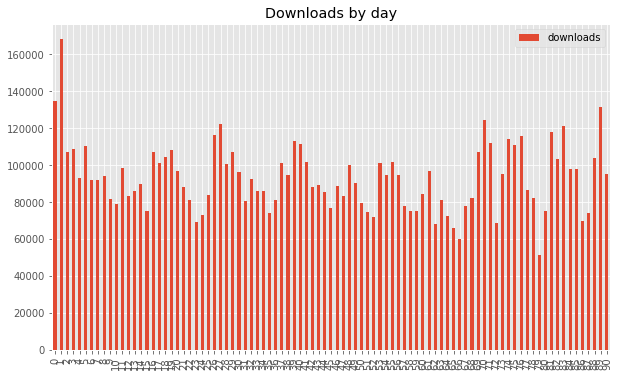

In [12]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [13]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
""", conn)

searches = df.values[0][0]
searches

56200613

In [14]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2021-04-01,19101324
1,2021-05-01,18305260
2,2021-06-01,18794029


In [15]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

searches_by_day

,day,searches
0,2021-04-01,889337
1,2021-04-02,895889
2,2021-04-03,780547
3,2021-04-04,770063
4,2021-04-05,639760
...,...,...
86,2021-06-26,568262
87,2021-06-27,528281
88,2021-06-28,643457
89,2021-06-29,688179


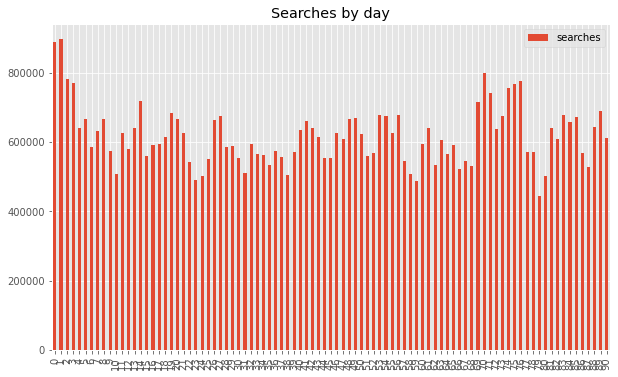

In [16]:
p = searches_by_day.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [17]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,13937 days 00:11:17.998327


In [18]:
time_saved_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 day' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{one_year_ago}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

time_saved_by_month

,month,time_saved_in_month
0,2020-07-01,8803 days 06:58:40.185313
1,2020-08-01,11274 days 21:23:53.931867
2,2020-09-01,9542 days 09:45:47.040065
3,2020-10-01,8074 days 17:26:14.875176
4,2020-11-01,6374 days 06:58:39.848346
5,2020-12-01,3878 days 06:59:28.147684
6,2021-01-01,3727 days 17:44:07.111225
7,2021-02-01,5639 days 08:25:11.612328
8,2021-03-01,6756 days 17:05:34.494183
9,2021-04-01,5148 days 08:09:03.090226


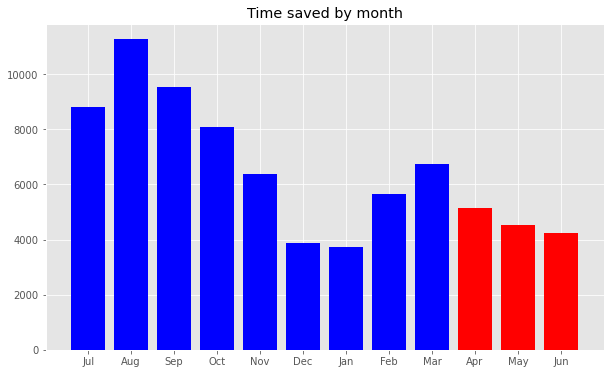

In [19]:
months = [m.month_name()[:3] for m in time_saved_by_month['month']]
days_saved = [ts.days for ts in time_saved_by_month['time_saved_in_month']]

colors = ['blue']*9 + ['red']*3
plt.bar(range(12), days_saved, color=colors)
plt.title('Time saved by month')
plt.xticks(range(12), months)

plt.savefig('time-saved-by-month.png')

plt.show()

In [20]:
top_10_downloads = pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 10;
""", conn)

top_10_downloads

,package,c
0,requests,153175
1,chardet,150367
2,numpy,140902
3,importlib-metadata,131558
4,octoprint-pisupport,124520
5,pip,118897
6,idna,109821
7,h11,104934
8,urllib3,99970
9,typing-extensions,99920


In [21]:
print("<ol>")
for i, row in top_10_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (153,175)</li>
<li><strong><a href='https://www.piwheels.org/project/chardet'>chardet</a></strong> (150,367)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (140,902)</li>
<li><strong><a href='https://www.piwheels.org/project/importlib-metadata'>importlib-metadata</a></strong> (131,558)</li>
<li><strong><a href='https://www.piwheels.org/project/octoprint-pisupport'>octoprint-pisupport</a></strong> (124,520)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (118,897)</li>
<li><strong><a href='https://www.piwheels.org/project/idna'>idna</a></strong> (109,821)</li>
<li><strong><a href='https://www.piwheels.org/project/h11'>h11</a></strong> (104,934)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (99,970)</li>
<li><strong><a href='https://www.piwheels.org/project/typing-extensions'>typing-ext

In [22]:
top_10_searches = pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_searches

,package,c
0,pip,8729381
1,wheel,5982230
2,setuptools,3978520
3,pyrogram,1502564
4,future,751603
5,youtube-dl,749239
6,aiohttp,696422
7,pyngrok,661208
8,aiodns,649962
9,six,547745


In [23]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (8,729,381)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (5,982,230)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (3,978,520)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (1,502,564)</li>
<li><strong><a href='https://www.piwheels.org/project/future'>future</a></strong> (751,603)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (749,239)</li>
<li><strong><a href='https://www.piwheels.org/project/aiohttp'>aiohttp</a></strong> (696,422)</li>
<li><strong><a href='https://www.piwheels.org/project/pyngrok'>pyngrok</a></strong> (661,208)</li>
<li><strong><a href='https://www.piwheels.org/project/aiodns'>aiodns</a></strong> (649,962)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (547,745)</li>
</ol>


In [24]:
top_10_project_pages = pd.read_sql(f"""
    select package, count(*) c
    from project_page_hits
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_pages

,package,c
0,opencv-python,1210
1,opencv-contrib-python,1108
2,numpy,981
3,scipy,700
4,tensorflow,686
5,qhub-jupyterhub-theme,493
6,pillow,445
7,cryptography,429
8,pandas,381
9,pip,335


In [25]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (1,210)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (1,108)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (981)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (700)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (686)</li>
<li><strong><a href='https://www.piwheels.org/project/qhub-jupyterhub-theme'>qhub-jupyterhub-theme</a></strong> (493)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (445)</li>
<li><strong><a href='https://www.piwheels.org/project/cryptography'>cryptography</a></strong> (429)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pandas</a></strong> (381)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</

In [26]:
top_10_project_json = pd.read_sql(f"""
    select package, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

top_10_project_json

,package,c
0,awscrt,12815
1,numpy,220
2,requirements-parser,91
3,scipy,62
4,opencv-python,58
5,requests,46
6,notion2alfred-snippet,43
7,pyyaml,40
8,devjohn06test,38
9,opencv-contrib-python,37


In [27]:
print("<ol>")
for pkg, c in top_10_project_json.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/awscrt'>awscrt</a></strong> (12,815)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (220)</li>
<li><strong><a href='https://www.piwheels.org/project/requirements-parser'>requirements-parser</a></strong> (91)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (62)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (58)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (46)</li>
<li><strong><a href='https://www.piwheels.org/project/notion2alfred-snippet'>notion2alfred-snippet</a></strong> (43)</li>
<li><strong><a href='https://www.piwheels.org/project/pyyaml'>pyyaml</a></strong> (40)</li>
<li><strong><a href='https://www.piwheels.org/project/devjohn06test'>devjohn06test</a></strong> (38)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>o

In [28]:
pd.read_sql(f"""
    select count(distinct(package)) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,c
0,82603


In [29]:
pd.read_sql(f"""
    select user_agent, count(*) c
    from project_json_downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by user_agent
    order by c desc
""", conn)

,user_agent,c
0,mozilla,102782
1,python-urllib,12943
2,ccbot,395
3,node-fetch,123
4,python-requests,85
5,goodbot,40
6,geturl,34
7,lanaibot please contact contactlanaibot@gmail....,25
8,linguee bot (http:,15
9,lanaibotapr1,8


In [30]:
os_usage = pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by os_name
    order by c desc
""", conn)

os_usage

,os_name,c
0,Linux,56167991
1,Darwin,18367
2,Windows,11247
3,FreeBSD,2394
4,OpenBSD,569
5,None,41
6,Salman Rahwidean Janotama,2
7,Dewandiaksa SM,1
8,Ajie Kurniawan S,1


In [31]:
linux_usage_pc = 100 * (os_usage.values[0][1] / searches)
print(f'{linux_usage_pc:2.2f}% linux')

99.94% linux


In [32]:
distro_usage = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 5
""", conn)

distro_usage

,distro_name,c
0,Raspbian GNU/Linux,49808463
1,Debian GNU/Linux,5735305
2,Ubuntu,517307
3,Alpine Linux,29273
4,Red Hat Enterprise Linux Server,27245


In [33]:
debian_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    order by c desc
    limit 5
""", conn)

debian_usage

,c
0,55543768


In [34]:
debian_usage_pc = 100 * (debian_usage.c[0] / searches)
print(f'{debian_usage_pc:2.2f}% debian')

98.83% debian


In [35]:
ubuntu_usage = pd.read_sql(f"""
    select count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name = 'Ubuntu'
    order by c desc
    limit 5
""", conn)

ubuntu_usage_pc = 100 * (ubuntu_usage.c[0] / searches)
print(f'{ubuntu_usage_pc:2.2f}% ubuntu')

0.92% ubuntu


In [59]:
debian = debian_usage.values[0][0]
others = searches - debian

distro_usage = {
    'Debian / Raspberry Pi OS': debian,
    'Others': others,
}

distro_usage

{'Debian / Raspberry Pi OS': 55543768, 'Others': 656845}

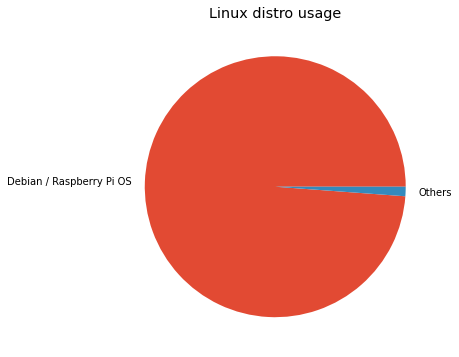

In [60]:
plt.pie(distro_usage.values(), labels=distro_usage.keys())
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [38]:
distro_versions = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

distro_versions

,distro_version,c
0,10,52049617
1,9,3415782
2,8,1278


In [39]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

10 93.8%
9 6.2%
8 0.0%


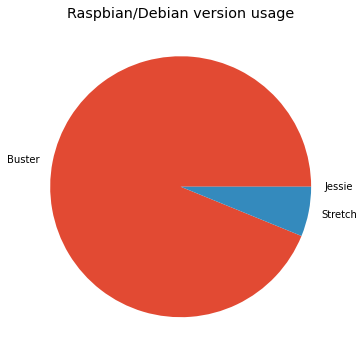

In [40]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c, labels=[version_names[v] for v in distro_versions.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [62]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,41318543
1,aarch64,8775655
2,x86_64,4157557
3,armv6l,1876199
4,i686,40499
5,AMD64,11247
6,armv8l,10101
7,arm64,7640
8,amd64,2963
9,ppc64le,135


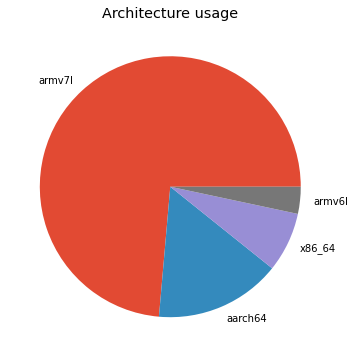

In [65]:
plt.pie(arch.c[:4], labels=arch.arch[:4])
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [43]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

armv7l 79.6%
aarch64 16.8%
armv6l 3.6%


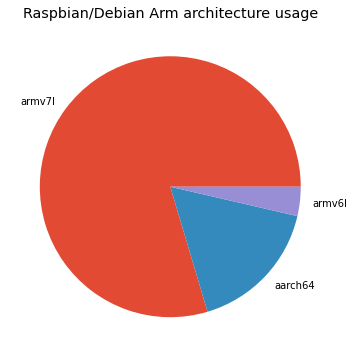

In [44]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [45]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 6
""", conn)

py_vers

,pyver,c
0,3.7,36773442
1,2.7,7941645
2,3.8,3509013
3,3.9,1664067
4,3.5,1562918
5,3.6,367980


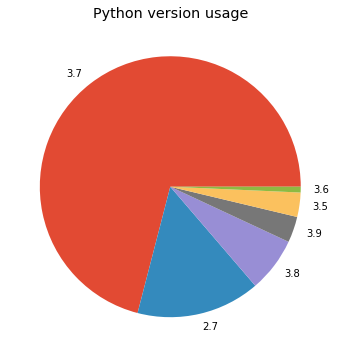

In [46]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

In [47]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

3.7 70.97%
2.7 15.33%
3.8 6.77%
3.9 3.21%
3.5 3.02%
3.6 0.71%


In [48]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,21.1.2,13562312
1,18.1,12414762
2,21.0.1,9830117
3,21.1.1,8027994
4,21.1,1748748
5,19.0.1,1501309
6,9.0.1,1436057
7,21.1.3,1435949
8,20.3.4,1187729
9,20.3.3,985534


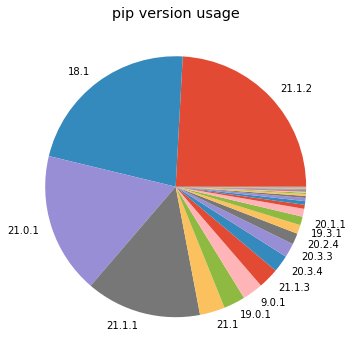

In [49]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [50]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at >= '{start_time}' AND accessed_at < '{end_time}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,26933766
1,57.0.0,7295780
2,56.0.0,3236865
3,41.2.0,2763925
4,56.2.0,2148493
5,40.7.1,1493317
6,53.1.0,1440726
7,49.2.1,1228322
8,54.2.0,938802
9,51.1.2,763037


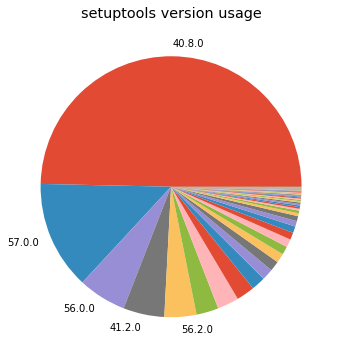

In [51]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()

In [52]:
import csv
from glob import glob
from collections import defaultdict

In [53]:
ONE_TB = 1e12
months = ('202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106')

bandwidth = {}
bandwidth_totals = defaultdict(int)
for month in months:
    bandwidth[month] = defaultdict(int)
    files = glob('/home/ben/piwheels-logs/' + month + '/*-sizes.csv')
    for file in files:
        with open(file) as f:
            r = csv.reader(f)
            for log_type, count in r:
                bandwidth[month][log_type] += int(count)
                bandwidth_totals[month] += int(count) / ONE_TB

In [54]:
for month, data in bandwidth_totals.items():
    print(month, f'{data:.2f} TB')

202007 3.92 TB
202008 6.38 TB
202009 6.27 TB
202010 6.58 TB
202011 4.43 TB
202012 3.32 TB
202101 3.79 TB
202102 5.87 TB
202103 7.07 TB
202104 5.35 TB
202105 4.82 TB
202106 4.72 TB


In [55]:
m1, m2, m3 = months[-3:]

bandwidth_in_period = {
    'pip downloads': bandwidth[m1]['LOGDOWNLOAD'] + bandwidth[m2]['LOGDOWNLOAD'] + bandwidth[m3]['LOGDOWNLOAD'],
    'Misc': bandwidth[m1]['OTHER'] + bandwidth[m2]['OTHER'] + bandwidth[m3]['OTHER'],
    'Searches': bandwidth[m1]['LOGSEARCH'] + bandwidth[m2]['LOGSEARCH'] + bandwidth[m3]['LOGSEARCH'],
    '': (
        bandwidth[m1]['LOGPROJECT'] + bandwidth[m2]['LOGPROJECT'] + bandwidth[m3]['LOGPROJECT'] +
        bandwidth[m1]['LOGJSON'] + bandwidth[m2]['LOGJSON'] + bandwidth[m3]['LOGJSON'] +
        bandwidth[m1]['LOGPAGE'] + bandwidth[m2]['LOGPAGE'] + bandwidth[m3]['LOGPAGE']
    ),
}

bandwidth_in_period

{'pip downloads': 12508507792700,
 'Misc': 1939319281327,
 'Searches': 435480540129,
 '': 10516781945}

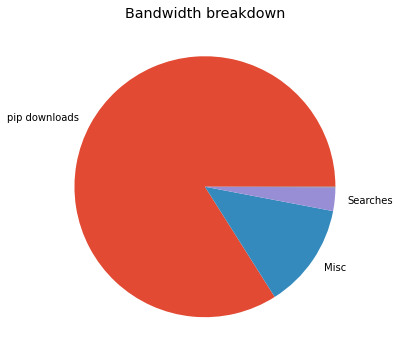

In [56]:
plt.pie(bandwidth_in_period.values(), labels=bandwidth_in_period.keys())
plt.title('Bandwidth breakdown')

plt.savefig('bandwidth.png')

plt.show()

In [57]:
for k, v in bandwidth_in_period.items():
    pc = 100 * (v / sum(bandwidth_in_period.values()))
    print(k, f'{pc:.2f}%')

pip downloads 83.98%
Misc 13.02%
Searches 2.92%
 0.07%


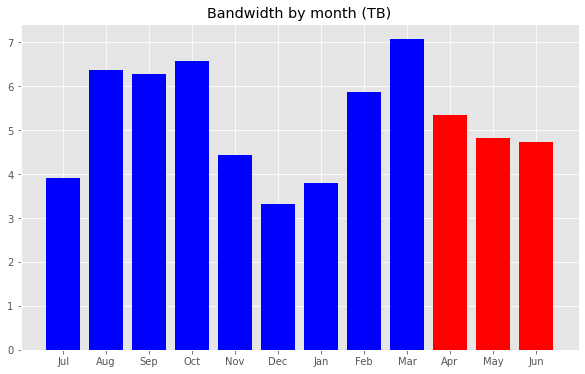

In [58]:
bandwidth_by_month = {
    'Jul': bandwidth_totals['202007'],
    'Aug': bandwidth_totals['202008'],
    'Sep': bandwidth_totals['202009'],
    'Oct': bandwidth_totals['202010'],
    'Nov': bandwidth_totals['202011'],
    'Dec': bandwidth_totals['202012'],
    'Jan': bandwidth_totals['202101'],
    'Feb': bandwidth_totals['202102'],
    'Mar': bandwidth_totals['202103'],
    'Apr': bandwidth_totals['202104'],
    'May': bandwidth_totals['202105'],
    'Jun': bandwidth_totals['202106'],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(bandwidth_by_month)), bandwidth_by_month.values(), color=colors)
plt.title('Bandwidth by month (TB)')
plt.xticks(range(len(bandwidth_by_month)), list(bandwidth_by_month.keys()))

plt.savefig('bandwidth-by-month.png')

plt.show()